In [8]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass


    return data

def arrayToColors(data):

    data=(data-np.min(data))/(np.max(data)-np.min(data))
    return mpl.cm.plasma(np.array(data))

def getData():
    data=[]
    
    files=glob.glob("pointyMinData/*")
    badFiles=[]

    for name in files:
        pointiness,temp=name.split("spacing")
        spacing,length=temp.split("length")
        pointiness=float(pointiness[24:-1])
        spacing=float(spacing[:-1])
        length=float(length[:-4])

        try:
            thisData=loadFile(name+"/table.txt")
            thisData.attrs["pointiness"]=pointiness
        
            thisData.attrs["spacing"]=spacing
            thisData.attrs["length"]=length
            data.append(thisData)
        except Exception as e:
            badFiles.append(name)
            continue


    print(f"Could not load {len(badFiles)}/{len(files)} file")
    return data

data=getData()


def getClosestPlot(spacing,pointiness,length):
    minDist=None
    bestRun=None
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)+abs(run.attrs["pointiness"]-pointiness)+abs(run.attrs["length"]-length)
        if minDist is None or dist<minDist:
            minDist=dist
            bestRun=run
    return bestRun

def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    for i in data:
        if i.attrs["pointiness"] not in pointinessVals: pointinessVals.append(i.attrs["pointiness"])
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()

    return pointinessVals, spacingVals, lengthVals

pointinessVals, spacingVals, lengthVals = getPossibleVals(data)


Could not load 0/153 file


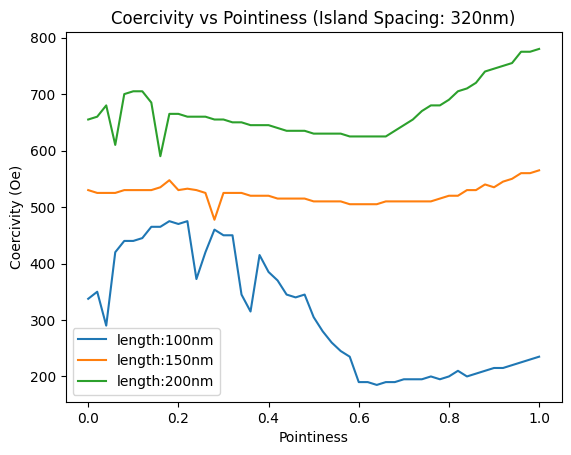

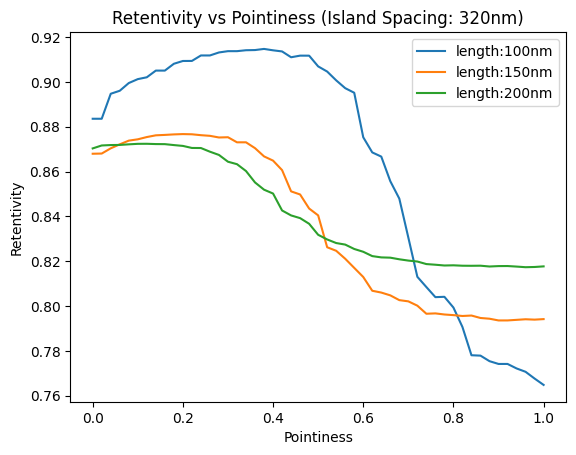

In [31]:
for length in lengthVals:
    thisHc=[]
    thisPointiness=[]
    for pointiness in pointinessVals:
        thisData=getClosestPlot(0,pointiness,length)
        thisHc.append(thisData.attrs["Hc"])
        thisPointiness.append(pointiness)
    plt.plot(thisPointiness,thisHc,label=f"length:{round(length*1e9)}nm")
    
plt.title("Coercivity vs Pointiness (Island Spacing: 320nm)")
plt.xlabel("Pointiness")
plt.ylabel("Coercivity (Oe)")
plt.legend()
plt.show()

for length in lengthVals:
    thisBr=[]
    thisPointiness=[]
    for pointiness in pointinessVals:
        thisData=getClosestPlot(0,pointiness,length)
        thisBr.append(thisData.attrs["Br"])
        thisPointiness.append(pointiness)
    plt.plot(thisPointiness,thisBr,label=f"length:{round(length*1e9)}nm")

plt.title("Retentivity vs Pointiness (Island Spacing: 320nm)")
plt.xlabel("Pointiness")
plt.ylabel("Retentivity")
plt.legend()
plt.show()